### Regime Detection

In this section we illustrate the concept of regime detection. 

In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yfinance as yf
import pandas as pd
import random

import numpy as np
import scipy.stats as scs

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from collections import Counter, deque
from imblearn.under_sampling import RandomUnderSampler

/tmp/ipykernel_17109/1569880688.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = yf.download('^GSPC', start="2017-01-01", end="2023-01-01", interval="1d")
df.head()

/home/codespace/.python/current/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,2251.570068,2263.879883,2245.129883,2257.830078,2257.830078,3773010000
2017-01-04,2261.600098,2272.820068,2261.600098,2270.750000,2270.750000,3768890000
2017-01-05,2268.179932,2271.500000,2260.449951,2269.000000,2269.000000,3785080000
2017-01-06,2271.139893,2282.100098,2264.060059,2276.979980,2276.979980,3342080000
2017-01-09,2273.590088,2275.489990,2268.899902,2268.899902,2268.899902,3219730000


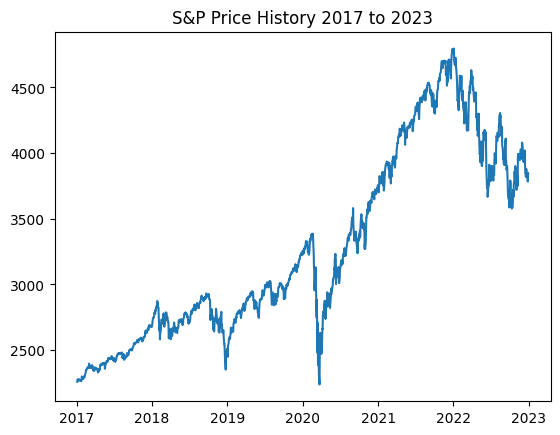

In [3]:
plt.title(f'S&P Price History 2017 to 2023')
plt.plot(
    list(i for i in df.index),
    list(i[4] for i in df.values))
plt.grid(False)

<Axes: title={'center': 'Excess returns'}, xlabel='Date'>

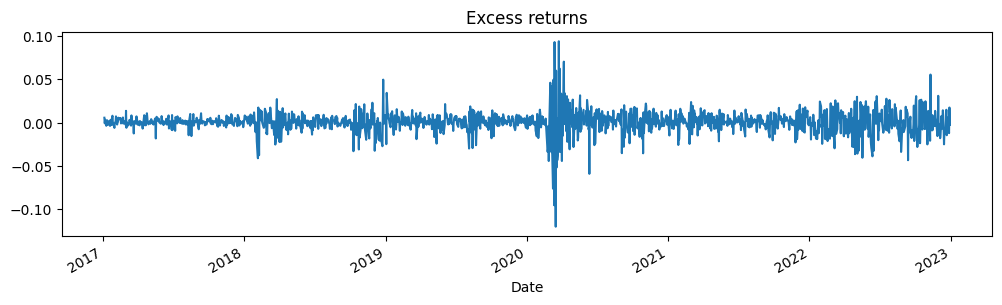

In [4]:
df['r-1'] = df['Adj Close'].pct_change().dropna()

ex_ret = df['r-1']
ex_ret.plot(title='Excess returns', figsize=(12, 3), grid=False)

In [5]:
# Fit the model
mod_kns = sm.tsa.MarkovRegression(ex_ret.dropna(), k_regimes=2, trend='n', switching_variance=True)
res_kns = mod_kns.fit()
res_kns.summary()

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                    r-1   No. Observations:                 1509
Model:               MarkovRegression   Log Likelihood                4866.951
Date:                Thu, 22 Feb 2024   AIC                          -9725.901
Time:                        15:50:19   BIC                          -9704.624
Sample:                             0   HQIC                         -9717.977
                               - 1509                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.164e-05   2.41e-06     13.124      0.000    2.69e-05    3.64e-05
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0004    2.5e-05     14.492      0.000       0.000       0.000
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9810      0.006    170.972      0.000       0.970       0.992
p[1->0]        0.0293      0.009      3.308      0.001       0.012       0.047
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [6]:
res_kns.smoothed_marginal_probabilities.head()


,0,1
Date,,
2017-01-04,0.986875,0.013125
2017-01-05,0.995670,0.004330
2017-01-06,0.998204,0.001796
2017-01-09,0.999107,0.000893
2017-01-10,0.999479,0.000521


In [7]:
print(res_kns.smoothed_marginal_probabilities.head())


                   0         1
Date                          
2017-01-04  0.986875  0.013125
2017-01-05  0.995670  0.004330
2017-01-06  0.998204  0.001796
2017-01-09  0.999107  0.000893
2017-01-10  0.999479  0.000521


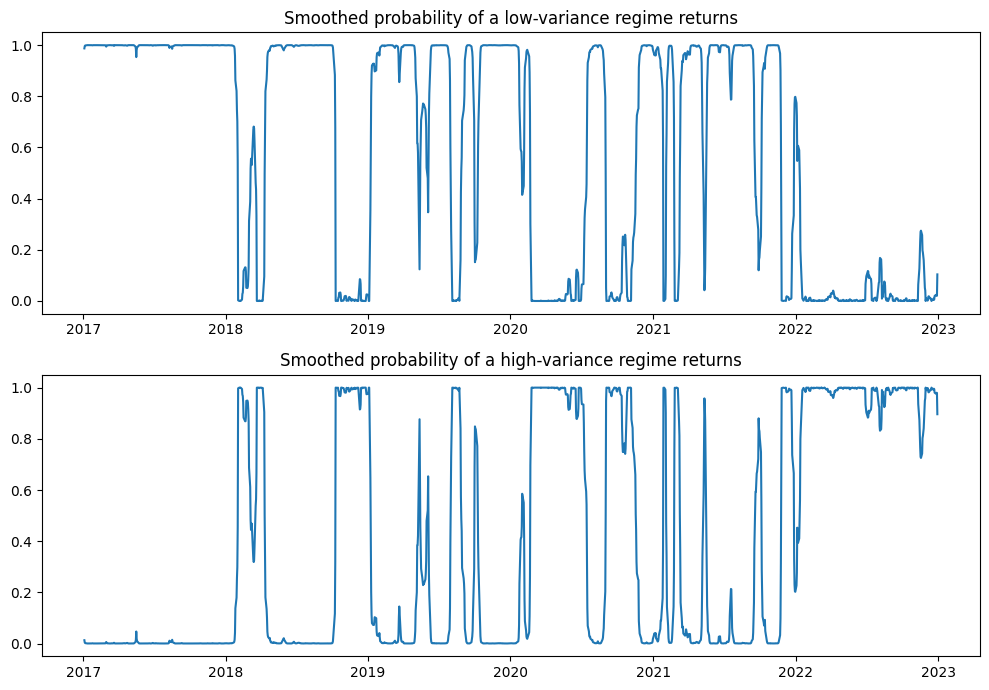

In [8]:
fig, axes = plt.subplots(2, figsize=(10,7))
ax = axes[0]
ax.plot(res_kns.smoothed_marginal_probabilities[0])
ax.grid(False)
ax.set(title='Smoothed probability of a low-variance regime returns')
ax = axes[1]
ax.plot(res_kns.smoothed_marginal_probabilities[1])
ax.set(title='Smoothed probability of a high-variance regime returns')
fig.tight_layout()
ax.grid(False)

In [9]:
low_var = list(res_kns.smoothed_marginal_probabilities[0])
high_var = list(res_kns.smoothed_marginal_probabilities[1])

regime_list = []
for i in range(0, len(low_var)):
    if low_var[i] > high_var[i]:
        regime_list.append(0)
    else:
        regime_list.append(1)

In [10]:
regime_df = pd.DataFrame()
regime_df['regimes'] = regime_list

Text(0.5, 0.98, 'Historical S&P 500 regimes')

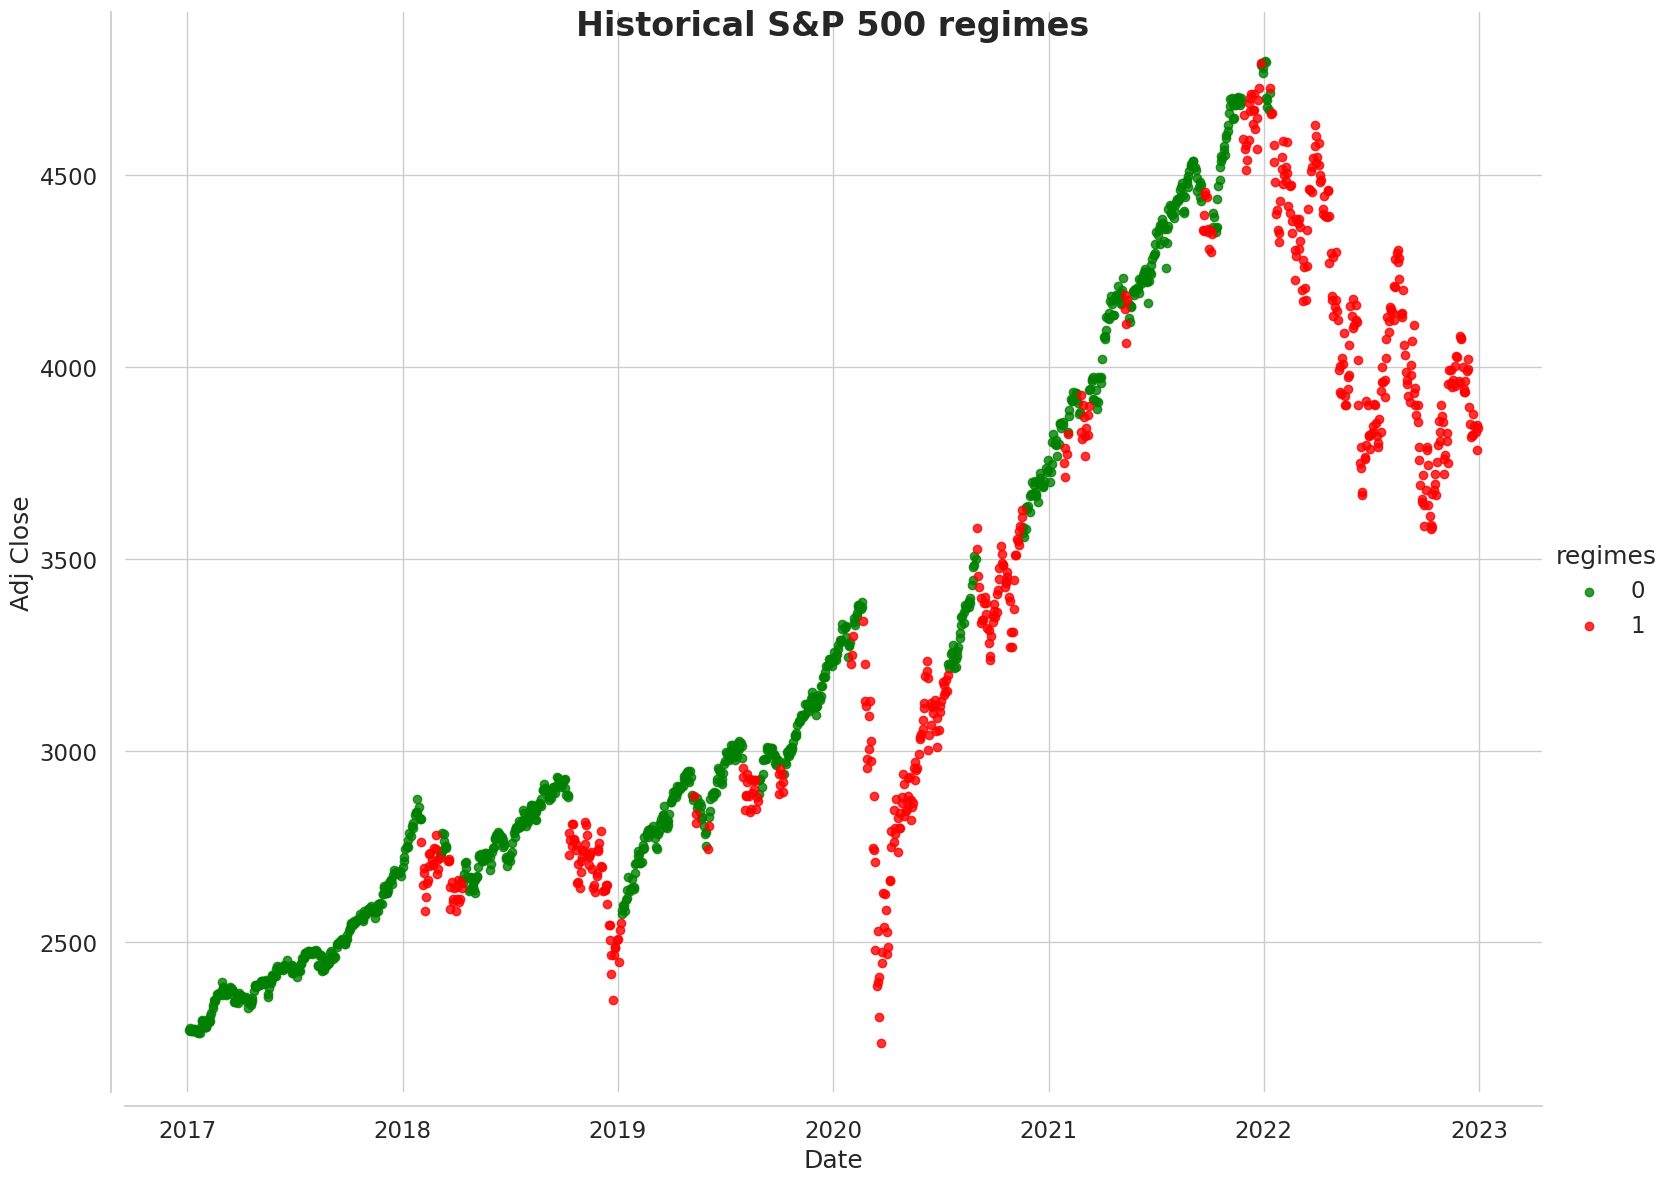

In [11]:
sns.set(font_scale=1.5)
df = df.iloc[len(df)-len(regime_list):]
regimes = (pd.DataFrame(regime_list, columns=['regimes'], index=df.index)
          .join(df, how='inner')
          .reset_index(drop=False)
          .rename(columns={'index':'Date'}))
regimes.head()

import warnings
warnings.filterwarnings("ignore")
colors = 'green', 'red', 'yellow'
sns.set_style("whitegrid")
order = [0, 1]
fg = sns.FacetGrid(data=regimes, hue='regimes', hue_order=order,
                   palette=colors, aspect=1.31, height=12)
fg.map(plt.scatter, 'Date', "Adj Close", alpha=0.8).add_legend()
sns.despine(offset=10)
fg.fig.suptitle('Historical S&P 500 regimes', fontsize=24, fontweight='demi')

During periods of volatility, generally around major market decline, we see high variance regime returns (red) confirming our hypothesis. During periods of low volatility, generally during calm uptrends we see low variance regime returns (green). From an investors perspective this graph can be interpreted simply, buy or hold assets during green periods and sell holdings as soon as possible in red periods.A Markov switching regression is good at telling us what regime we were just in, ‘nowcasting’, but it doesn’t not necessarily give us much information about the next regime. A machine learning model can provide just that, giving us an expectation of the next regime.

### Utilizing KMeans 

In [2]:
# import libraries:
#
import datetime
#
from sklearn.cluster import KMeans
#
import matplotlib.pyplot as plt
import numpy as np
import pandas_ta as ta
import yfinance as yf

In [3]:
# get asset of interest: SP500 ticker:
asset = '^GSPC'
end_time = datetime.date.today()
# start_time = end_time - datetime.timedelta(days = 11850)
start_time = end_time - datetime.timedelta(days = 1850)
df = yf.download(asset, start=start_time, end=end_time)
df_orig = yf.download(asset, start=start_time, end=end_time)

/home/codespace/.python/current/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
/home/codespace/.python/current/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


In [4]:
# retrieve additional features:
# VIX at close prices
VIX = yf.download('^VIX', start=start_time, end=end_time)
df['VIX']=VIX['Close']
# compute ATR technical indicator
df.ta.atr(length=14, append=True)
# compute relative Volume on a rolling basis
df['relative_Vol'] = df['Volume']/df['Volume'].rolling(40).mean()
# get the daily returns of SPX500 to perform the regime detection:
df['return'] = df['Close'] - df['Close'].shift(1)

/home/codespace/.python/current/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


/tmp/ipykernel_36908/3576421940.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


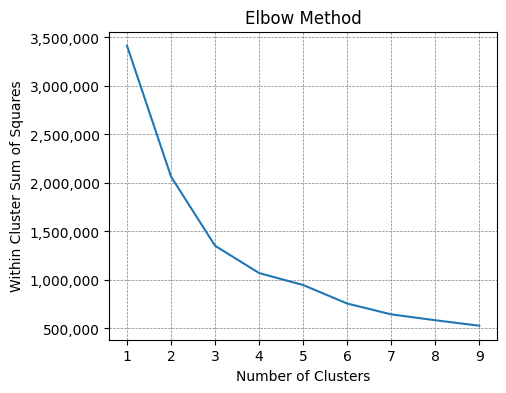

In [5]:
# Elbow method to find optimal number of regimes

df = df[['return', 'VIX', 'ATRr_14', 'relative_Vol']]

df = df[40:]
df_orig = df_orig[40:]

#within cluster sum of squares:
wcss = []

num_clusters = list(range(1,10))

for i in num_clusters:
    kmeans=KMeans(i)
    kmeans.fit(df)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)
    
fig = plt.figure(figsize =(5, 4))
plt.plot(num_clusters,wcss)
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.title('Elbow Method')
plt.ylabel('Within Cluster Sum of Squares')
plt.xlabel('Number of Clusters')
plt.xticks(np.arange(min(num_clusters), max(num_clusters)+1, 1.0))
plt.ticklabel_format(style='plain')
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels([round(x) for x in current_values])
plt.show()

In [6]:
# It seems that it is optimal to choose 3 or 4 clusters/regimes so let’s go ahead with 3 clusters.
kmeans_num = 3
kmeans = KMeans(kmeans_num)
df['regime'] = kmeans.fit_predict(df)
df_orig['regime'] = df['regime']


In [7]:
print(df)


               return    VIX    ATRr_14  relative_Vol  regime
Date                                                         
2019-03-27 -13.089844  15.15  28.535758      0.902427       0
2019-03-28  10.069824  14.43  27.965898      0.843832       0
2019-03-29  18.959961  13.71  27.414524      1.002019       0
2019-04-01  32.790039  13.40  27.979691      0.952048       0
2019-04-02   0.050049  13.36  26.952445      0.874323       0
...               ...    ...        ...           ...     ...
2024-02-14  47.450195  14.38  43.824128      1.001976       2
2024-02-15  29.109863  14.01  43.070996      1.077608       0
2024-02-16 -24.160156  14.24  42.793080      0.999519       0
2024-02-20 -30.060059  15.42  43.347132      1.053231       0
2024-02-21   6.290039  15.34  42.908762      0.986590       0

[1235 rows x 5 columns]


In [8]:
print(df_orig)

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2019-03-27  2819.719971  2825.560059  2787.719971  2805.370117  2805.370117   
2019-03-28  2809.399902  2819.709961  2798.770020  2815.439941  2815.439941   
2019-03-29  2828.270020  2836.030029  2819.229980  2834.399902  2834.399902   
2019-04-01  2848.629883  2869.399902  2848.629883  2867.189941  2867.189941   
2019-04-02  2868.239990  2872.899902  2858.750000  2867.239990  2867.239990   
...                 ...          ...          ...          ...          ...   
2024-02-14  4976.439941  5002.520020  4956.450195  5000.620117  5000.620117   
2024-02-15  5003.140137  5032.720215  4999.439941  5029.729980  5029.729980   
2024-02-16  5031.129883  5038.700195  4999.520020  5005.569824  5005.569824   
2024-02-20  4989.319824  4993.709961  4955.020020  4975.509766  4975.509766   
2024-02-21  4963.029785  4983.209961  4946.000000  4

/tmp/ipykernel_36908/3629409398.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


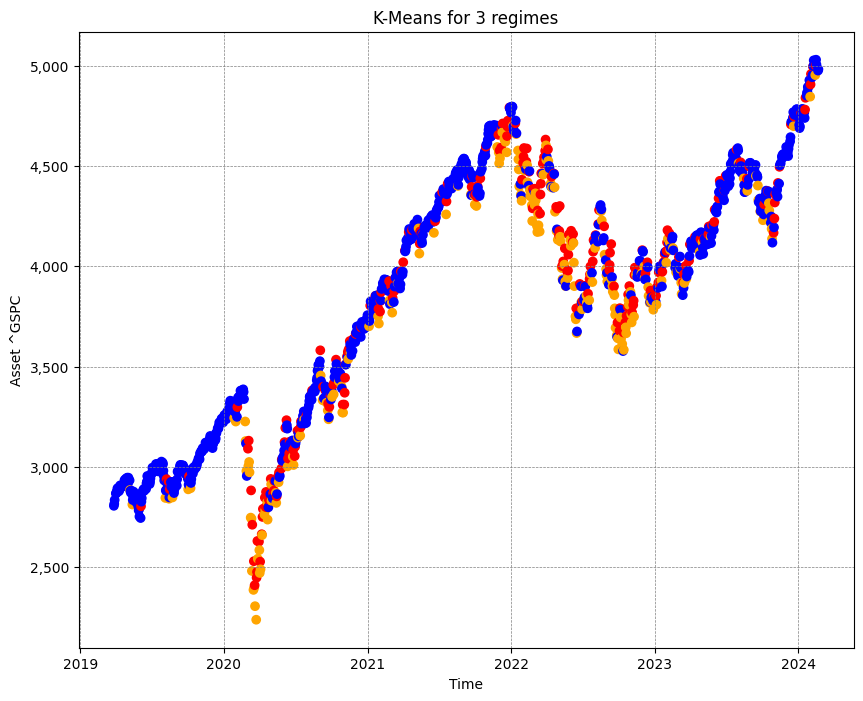

In [9]:
# Plot regimes

colours = []
vcs = {v: i for i, v in enumerate(df_orig.regime.value_counts().index)}
df_orig['freq_rank'] = df_orig.regime.apply(vcs.get)

for i in range(0,len(df_orig)):
    if df_orig['freq_rank'].iloc[i]==0:
        colours.append('blue')
    elif df_orig['freq_rank'].iloc[i]==1:
        colours.append('red')
    elif df_orig['freq_rank'].iloc[i]==2:
        colours.append('orange')
    else:
        colours.append('brown')
        
fig = plt.figure(figsize =(10, 8))
plt.scatter(df_orig.index, df_orig.Close, c=colours)
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.title(f'K-Means for {kmeans_num} regimes')
plt.ylabel(f'Asset {asset}')
plt.xlabel('Time')
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.show()